# Training a FNO on the linear Shallow Water equations on a 1D sphere


In [88]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time

## Functions

In [89]:
def prepare_data(h_all, x, p_train, p_val):
    x = x.squeeze()
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]
    a = a[:, np.newaxis, :]
    # Target u (one time step after a)
    u = h_all[1:]
    u = u[:, np.newaxis, :]

    mesh = x
    mesh_shape_corrected = np.repeat(mesh[np.newaxis, np.newaxis, :], u.shape[0], axis=0)

    # Concatenate a with mesh_shape_corrected
    a_with_mesh = np.concatenate([a, mesh_shape_corrected], axis=1)
    print(a_with_mesh.shape)

    # Concatenate u with mesh_shape_corrected
    u_with_mesh = np.concatenate([u, mesh_shape_corrected], axis=1)
    print(u_with_mesh.shape)

    n = len(a_with_mesh)
    print(n)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


In [90]:
def plot_loss(loss_train, loss_val, save=False, figname='plots/loss.pdf'):
    plt.figure(figsize=(7, 3))
    plt.plot(loss_train, '.-', label='Training loss', linewidth=1, markersize=2)
    plt.plot(loss_val, '.-', label='Validation loss', linewidth=1, markersize=2)
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.title('Training and validation loss for each epoch')
    #plt.title('Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

def plot_predictions_imshow(pred_all, train_x, val_x, test_x, u, x, time_all, save=False, figname='plots/predictions.pdf'):
    # Assuming x and time_all correspond to the spatial and time dimensions
    X, T = np.meshgrid(x, time_all.squeeze())

    # Plot predictions
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    cmap = 'Blues_r'

    # Define the extent based on X and T
    extent = [X.min(), X.max(), T.max(), T.min()]  

    # Prediction plot
    im1 = ax[0].imshow(pred_all[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[0].set_title("Predictions")
    ax[0].set_xlabel("Spatial domain (X)")
    ax[0].set_ylabel("Time (T)")
    ax[0].invert_yaxis()
    plt.colorbar(im1, ax=ax[0])

    # True solution plot
    im2 = ax[1].imshow(u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[1].set_title("True solution")
    ax[1].set_xlabel("Spatial domain (X)")
    ax[1].set_ylabel("Time (T)")
    ax[1].invert_yaxis()
    plt.colorbar(im2, ax=ax[1])

    # Difference plot
    im3 = ax[2].imshow(pred_all[:, 0, :] - u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[2].set_title("Difference")
    ax[2].set_xlabel("Spatial domain (X)")
    ax[2].set_ylabel("Time (T)")
    ax[2].invert_yaxis()
    plt.colorbar(im3, ax=ax[2])

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


def plot_predictions_3D(pred_all, u, mesh, time_all, save=False, figname='plots/predictions_3D.pdf'):
    # Prepare grid
    X, T = np.meshgrid(mesh, time_all[1:].squeeze())

    # Plot the output, predictions and absolute error
    fig = plt.figure(figsize=(18, 6))

    cmap = 'Blues_r'

    # Plot predictions in 3D
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X, T, u[:, 0, :], cmap=cmap)
    ax1.set_title("True solution for the water height h (m)")
    ax1.set_xlabel("Spatial domain x (m)")
    ax1.set_ylabel("Time t (s)")
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # Plot true solution in 3D
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X, T, pred_all[:, 0, :], cmap=cmap)
    ax2.set_title("Predictions for the water height h (m)")
    ax2.set_xlabel("Spatial domain x (m)")
    ax2.set_ylabel("Time t (s)")
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    # Plot difference in 3D
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(X, T, np.abs(pred_all[:, 0, :] - u[:, 0, :]), cmap=cmap)
    ax3.set_title("Absolute difference ")
    ax3.set_xlabel("Spatial domain x (m)")
    ax3.set_ylabel("Time t (s)")
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

def plot_predictions_time_steps(pred_all, u, mesh, indices, save=False, figname='plots/predictions_time_steps.pdf'):
    n = len(u)
    # Plot for some time steps
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(mesh, pred_all[indices[0], 0, :], label='FNO prediction')
    plt.plot(mesh, u[indices[0], 0, :], label='True solution')
    plt.xlabel('x')
    plt.ylabel('h')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[0]}/{n}")

    plt.subplot(1, 3, 2)
    plt.plot(mesh, pred_all[indices[1], 0, :], label='FNO prediction')
    plt.plot(mesh, u[indices[1], 0, :], label='True solution')
    plt.xlabel('x')
    plt.ylabel('h')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[1]}/{n}")

    plt.subplot(1, 3, 3)
    plt.plot(mesh, pred_all[indices[2], 0, :], label='FNO prediction')
    plt.plot(mesh, u[indices[2], 0, :], label='True solution')
    plt.xlabel('x')
    plt.ylabel('h')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[2]}/{n}")

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


def plot_RMSE(pred_all, u, n_train, n_val, save=False, figname='plots/RMSE.pdf'):
    # Plot the RMSE in each time step
    rmse = np.sqrt(np.mean((pred_all - u) ** 2, axis=(1, 2)))
    print(rmse.shape)

    plt.figure(figsize=(10, 4))
    plt.plot(rmse, '.-', label='RMSE', linewidth=1, markersize=2)
    plt.axvline(x=n_train, color='r', linestyle='--', label='End of training set')
    plt.axvline(x=n_train + n_val, color='g', linestyle='--', label='End of validation set')
    plt.xlabel('Time step')
    plt.ylabel('RMSE')
    plt.title('RMSE in each time step')
    plt.legend()
    plt.grid()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

def plot_true_solution(u, mesh, time_all, save=False, figname='plots/true_solution.pdf'):
    # Prepare grid
    X, T = np.meshgrid(mesh, time_all[1:].squeeze())

    # Plot the true solution
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, T, u[:, 0, :], cmap='Blues_r')
    ax.set_title("True solution for the water height h (m)")
    ax.set_xlabel(r"Spatial domain $\theta$ (rad)")
    ax.set_ylabel("Time t (s)")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)    

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


def plot_error(pred_all, u, mesh, time_all, cmap='Blues_r', save=False, figname='plots/error.pdf'):
    # Prepare grid
    X, T = np.meshgrid(mesh, time_all[1:].squeeze())

    fig = plt.figure(figsize=(20, 6))

    # Subplots
    ax = fig.add_subplot(131, projection='3d')
    surf = ax.plot_surface(X, T, np.abs(pred_all[:, 0, :]), cmap=cmap)
    ax.set_title("Predictions of the water height (m)")
    ax.set_xlabel("Spatial domain x (m)")
    ax.set_ylabel("Time t (s)")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    ax = fig.add_subplot(132, projection='3d')
    surf = ax.plot_surface(X, T, np.abs(pred_all[:, 0, :] - u[:, 0, :]), cmap=cmap)
    ax.set_title("Absolute error (m)")
    ax.set_xlabel("Spatial domain x (m)")
    ax.set_ylabel("Time t (s)")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Add contour plot to the right
    ax2 = fig.add_subplot(133)
    ax2.imshow(np.abs(pred_all[:, 0, :] - u[:, 0, :]), cmap=cmap)
    ax2.set_title("Absolute error (m)")
    ax2.set_xlabel("Spatial domain x (m)")
    ax2.set_ylabel("Time t (s)")
    ax2.grid()
    ax2.invert_yaxis()
    # add colorbar
    fig.colorbar(surf, ax=ax2, shrink=0.8, aspect=10)    

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


## Inital condition: Gauss function

Load data from h5 file.

In [91]:
sigma = 3
save = 1

In [92]:
# Construct the file path dynamically
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\linear-SWE-sphere-1d_sigma={sigma},T=1.h5'

# Load data
with h5py.File(file_path, 'r') as file:
    for key in file.keys():
        print(key)
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_storage'])
    t_all = np.array(file['data_0']['t_storage'])
    theta_all = np.array(file['data_0']['theta'])
    theta_all = theta_all[:,:-1]

print(f'Loaded h_all with shape {h_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded theta_all with shape {theta_all.shape}')

data_0
  'data_0' is a group containing:
    h_storage
    t_storage
    theta
Loaded h_all with shape (402, 500)
Loaded t_all with shape (402, 1)
Loaded theta_all with shape (1, 500)


In [93]:
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, theta_all, p_train, p_val)

(401, 2, 500)
(401, 2, 500)
401
n_train = 240, n_val = 80, n_test = 81
torch.Size([240, 1, 500]) torch.Size([240, 1, 500]) torch.Size([80, 1, 500]) torch.Size([80, 1, 500]) torch.Size([81, 1, 500]) torch.Size([81, 1, 500])


In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## FNO

In [95]:
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 308929 parameters.

In [96]:
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [97]:
loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)

# Time training
start_time = time.time()

# Training loop
n_epochs = 100
for epoch in tqdm(range(n_epochs), unit='epoch'):
    model.train()
    epoch_train_loss = 0

    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate epoch loss
        epoch_train_loss += loss.item() * x.size(0) # loss.item() is the average loss of the batch

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad(): # Disable gradient tracking
        for x_val, y_val in dataloader_val:
            x_val = y_val.to(device)
            y_val = y_val.to(device)
            val_y_pred = model(x_val)
            val_loss = loss_fn(val_y_pred, y_val)
            epoch_val_loss += val_loss.item() * x_val.size(0) 
            

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 9:
        print(f'Epoch {epoch + 1}/{n_epochs}: Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}')


# Time training
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")



  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 10/100: Training loss: 0.001168, Validation loss: 0.001242
Epoch 20/100: Training loss: 0.000459, Validation loss: 0.000929
Epoch 30/100: Training loss: 0.000336, Validation loss: 0.001147
Epoch 40/100: Training loss: 0.000276, Validation loss: 0.001244
Epoch 50/100: Training loss: 0.000226, Validation loss: 0.001254
Epoch 60/100: Training loss: 0.000196, Validation loss: 0.001192
Epoch 70/100: Training loss: 0.000173, Validation loss: 0.001210
Epoch 80/100: Training loss: 0.000163, Validation loss: 0.001178
Epoch 90/100: Training loss: 0.000168, Validation loss: 0.001181
Epoch 100/100: Training loss: 0.000145, Validation loss: 0.001057
Training time: 110.55 seconds


Plot training and validation loss. Iteration = n_epochs x n_batches.

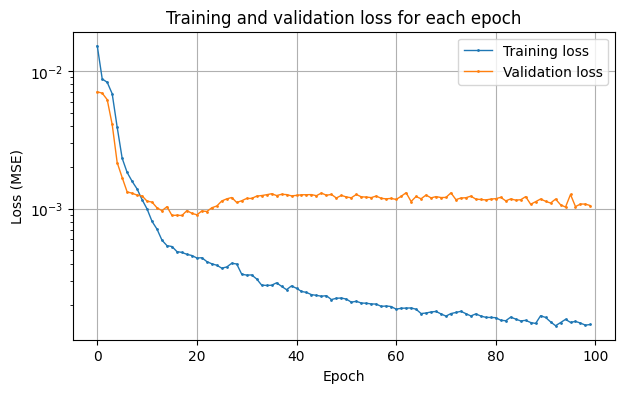

In [98]:
plt.figure(figsize=(7, 4))
plt.plot(loss_train, '.-', label='Training loss', linewidth=1, markersize=2)
plt.plot(loss_val, '.-', label='Validation loss', linewidth=1, markersize=2)
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Training and validation loss for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

if save:
    plt.savefig(f'plots/Spherical_linear_1D_FNO_sigma={sigma}.pdf', format='pdf')

plt.show()

In [99]:
# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(train_x).cpu().detach().numpy()
    pred_val = model(val_x).cpu().detach().numpy()
    pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

# Calculate loss
train_loss = loss_fn(torch.tensor(pred_train[:, 0, :]), torch.tensor(u[:n_train, 0, :])).item()
val_loss = loss_fn(torch.tensor(pred_val[:, 0, :]), torch.tensor(u[n_train:n_train + n_val, 0, :])).item()
test_loss = loss_fn(torch.tensor(pred_test[:, 0, :]), torch.tensor(u[n_train + n_val:, 0, :])).item()
all_loss = loss_fn(torch.tensor(pred_all[:, 0, :]), torch.tensor(u[:, 0, :])).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")
print(f"All loss: {all_loss:.2e}")


(401, 1, 500)
Train loss: 1.37e-04
Validation loss: 3.44e-04
Test loss: 5.17e-04
All loss: 2.55e-04


In [100]:
# Calculate MAE 
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train[:, 0, :]), torch.tensor(u[:n_train, 0, :])).item()
val_loss = loss_new(torch.tensor(pred_val[:, 0, :]), torch.tensor(u[n_train:n_train + n_val, 0, :])).item()
test_loss = loss_new(torch.tensor(pred_test[:, 0, :]), torch.tensor(u[n_train + n_val:, 0, :])).item()
all_loss = loss_new(torch.tensor(pred_all[:, 0, :]), torch.tensor(u[:, 0, :])).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")
print(f"All loss: {all_loss:.2e}")

Train loss: 5.82e-03
Validation loss: 9.78e-03
Test loss: 1.16e-02
All loss: 7.79e-03


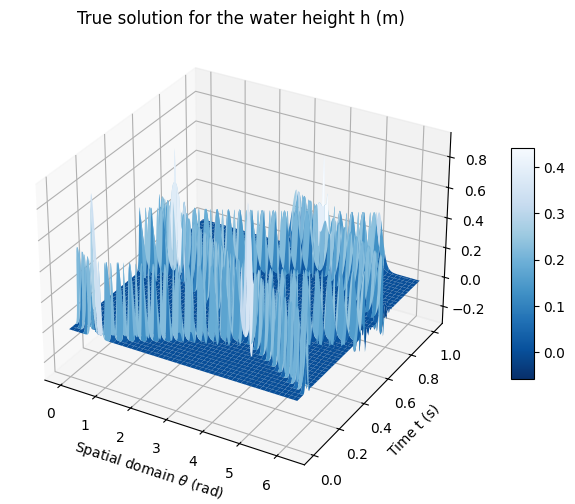

In [101]:
# Plot true solution
plot_true_solution(u, mesh, t_all, save=1, figname='plots/Spherical_linear_1D_true_solution.pdf')

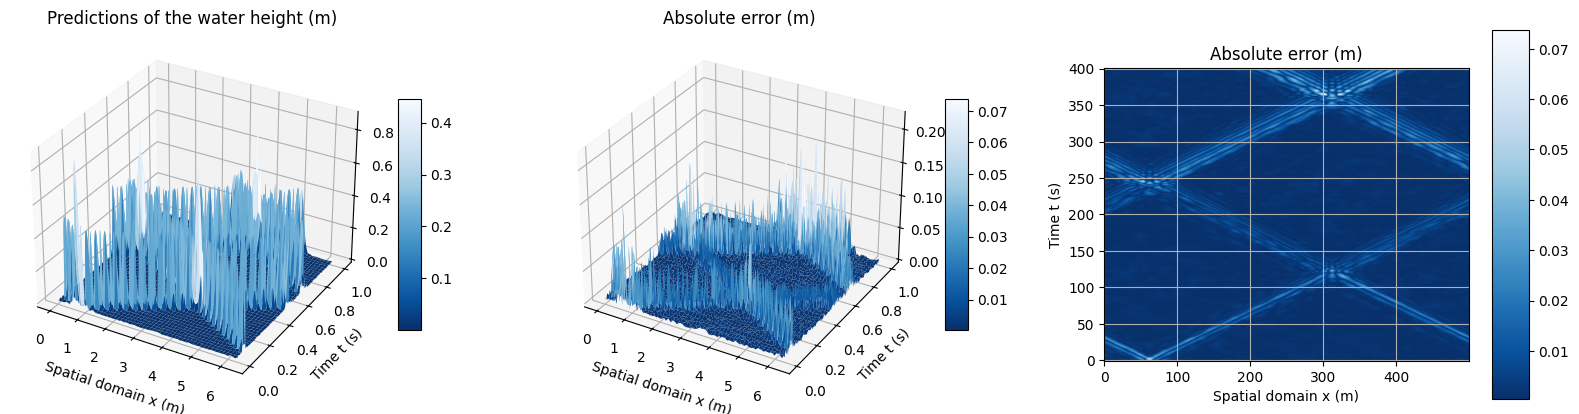

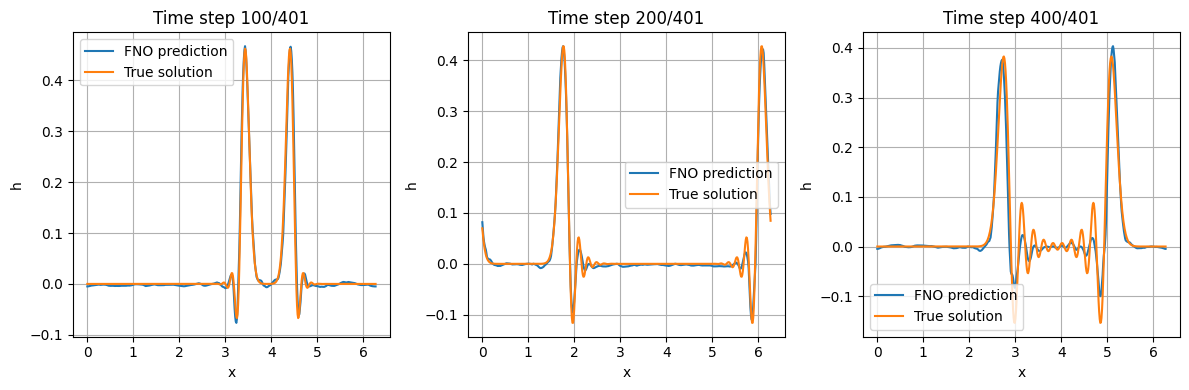

(401,)


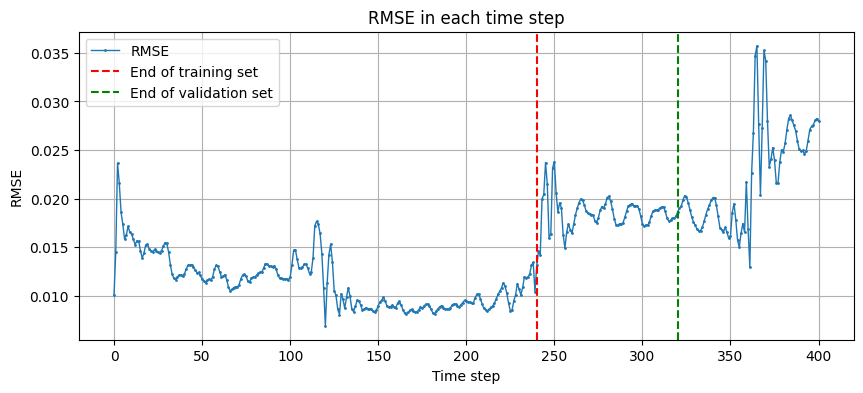

In [102]:
plot_error(pred_all, u, mesh, t_all, cmap='Blues_r', save=save, figname=f'plots/Spherical_linear_1D_FNO_error_sigma={sigma}.pdf')

#plot_predictions_imshow(pred_all, train_x, val_x, test_x, u, x, t_all, save=save, figname='plots/Spherical_linear_1D_FNO_predictions.pdf')
#plot_predictions_3D(pred_all, u, mesh, t_all, save=save, figname='plots/Spherical_linear_1D_FNO_predictions_3D.pdf')

indices = [100, 200, 400]
plot_predictions_time_steps(pred_all, u, mesh, indices, save=save, figname=f'plots/Spherical_linear_1D_FNO_timesteps_sigma={sigma}.pdf')
plot_RMSE(pred_all, u, n_train, n_val, save=save, figname=f'plots/Spherical_linear_1D_FNO_RMSE_sigma={sigma}.pdf')